# **Lab Assignment 1: Classification**
### **Authors:** Jose Carlos Riego, Ángel Visedo, Pablo Rodríguez

## **Information of the inputs and outputs:**
**INPUTS**
1. **ExternalRiskEstimate**: *Una medida del nivel de riesgo del prestatario basado en fuentes de datos externas consolidadas.*
2. **NetFractionRevolvingBurden**: *La proporción del uso actual del crédito de un individuo en comparación con su crédito máximo permitido.*
3. **AverageMInFile**: *La duración promedio, en meses, de los registros comerciales (préstamos pedidos?)en el expediente crediticio del prestatario.*
4. **MSinceOldestTradeOpen**: *La antigüedad, en meses, de la cuenta de crédito más antigua de un prestatario.*
5. **PercentInstallTrades**: *El porcentaje de cuentas de crédito del prestatario que tienen términos de pago fijos durante un período especificado ¿Número de préstamos que acaban en un plazo determinado?.*
6. **NumSatisfactoryTrades**: *Recuento de transacciones donde el prestatario ha cumplido satisfactoriamente con sus obligaciones.*
7. **NumTotalTrades**: *Número total de transacciones (número total de cuentas de crédito ¿PRÉSTAMOS?).*
8. **MSinceMostRecentInqexcl7days**: *Meses desde la última consulta de crédito, excluyendo la última semana.*
9. **PercentTradesNeverDelq**: *El porcentaje de transacciones del prestatario sin historial de morosidad.*

**OUTPUTS**
10. **Rendimiento de Riesgo (Risk Performance)**: *Bandera de "pagado según lo negociado" (12-36 meses). Variable de clase (0 o 1).* <br><br>

**Attribute Information:**
1. **ExternalRiskEstimate**: *A measure of the borrower's riskiness based on consolidated external data sources.*
2. **NetFractionRevolvingBurden**: *The proportion of an individual's current credit usage compared to their maximum allowed credit.*
3. **AverageMInFile**: *The average duration, in months, of the trades in a borrower's credit file.*
4. **MSinceOldestTradeOpen**: *The age, in months, of a borrower's oldest credit account.*
5. **PercentInstallTrades**: *The percentage of a borrower's credit accounts that have fixed payment terms over a specified period.*
6. **NumSatisfactoryTrades**: *Count of trades where a borrower has met obligations satisfactorily.*
7. **NumTotalTrades**: *Number of total trades (total number of credit accounts).*
8. **MSinceMostRecentInqexcl7days**: *Months since the last credit inquiry, ignoring the most recent week.*
9. **PercentTradesNeverDelq**: *The percentage of a borrower's trades with no history of delinquency.*
10. **Risk Performance**: *Paid as negotiated flag (12-36 months). Class variable (0 or 1).*


---

### **Libraries**

In [1]:
# interactive plotting
%matplotlib inline
%config InlineBackend.figure_format = 'svg' # ‘png’, ‘retina’, ‘jpeg’, ‘svg’, ‘pdf’


# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

import sys
import statsmodels.api as sm
import os

from sklearn.model_selection import train_test_split, cross_val_score,  GridSearchCV, KFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.compose import ColumnTransformer
from sklearn.neural_network import MLPClassifier
from sklearn.feature_selection import mutual_info_classif
from sklearn.decomposition import PCA
from sklearn.feature_selection import chi2
from sklearn.naive_bayes import GaussianNB
from neuralsens import partial_derivatives as ns
from sklearn.svm import SVC
from sklearn.calibration import CalibratedClassifierCV
sns.set_theme()


from utils import *

# Set the style for better-looking plots
plt.style.use('ggplot')
sns.set_palette("deep")

## **1. Preprocessing data**


### **1.1 Import dataset**

In [2]:
# Load file
df_raw = pd.read_csv('FICO_dataset_reduced_MOD.csv', sep=";") # raw indicates that the data has not been modified yet
display(df_raw.head())

,RiskPerformance,ExternalRiskEstimate,NetFractionRevolvingBurden,AverageMInFile,MSinceOldestTradeOpen,PercentTradesWBalance,PercentInstallTrades,NumSatisfactoryTrades,NumTotalTrades,PercentTradesNeverDelq,MSinceMostRecentInqexcl7days
0,1.0,55,33,84,144.0,69.0,43,20.0,23.0,83,0
1,1.0,61,0,41,58.0,0.0,67,2.0,7.0,100,0
2,1.0,67,53,24,66.0,86.0,44,9.0,9.0,100,0
3,1.0,66,72,73,169.0,91.0,57,28.0,30.0,93,0
4,1.0,81,51,132,333.0,80.0,25,12.0,12.0,100,0


<br><br>**Manage Special Characters** 

At the moment we are going to REMOVE only all rows containing the negative values -9, -8, -7 and store it in a new DataFrame called def_cleaned. So if we use df_raw, in plots we will see the negative values. 

In [3]:
df_cleaned = df_raw[~df_raw.isin([-9, -8, -7]).any(axis=1)] 

# Check for special values in the clean DataFrame
special_values_exist = df_cleaned.isin([-9, -8, -7]).any().any()

'''
- df_raw.isin([-9, -8, -7]): creates a boolean df with the same size as df_raw, where each cell is True if it has -9, -8, -7 and False otherwise
- .any(axis=1): check row by row if there is at least one True (i.e. at least one of the special values)
- ~: Invert the result. Converts True's in False's and vice versa. Rows without special values are True
- df_raw[...]: Filter df_raw, retaining only rows without special values. Result is stores in df_cleaned. 
'''

if special_values_exist:
    print("There are still special values [-9, -8, -7] in the clean DataFrame.")
else:
    print("There are NO special values in the clean DataFrame")


There are NO special values in the clean DataFrame


### **1.2 Search for missing values (NA's)**

In [4]:
# Check for missing values
print(df_cleaned.isnull().any())
missing_values = df_cleaned.isnull().sum()
#print(f"\nMissing values: \n{missing_values}")
print('\n')

print(missing_values[missing_values > 0])

# Convert to dictionary the missing values
missing_values_dict = missing_values.to_dict()
#print(missing_values_dict)
print(missing_values_dict['RiskPerformance'])
RiskP_missing_values = missing_values_dict['RiskPerformance']

num_rows = len(df_cleaned)
print(f'\n% of missing values in output: {(( RiskP_missing_values* 100)/num_rows)}')

RiskPerformance                  True
ExternalRiskEstimate            False
NetFractionRevolvingBurden      False
AverageMInFile                  False
MSinceOldestTradeOpen            True
PercentTradesWBalance            True
PercentInstallTrades            False
NumSatisfactoryTrades            True
NumTotalTrades                   True
PercentTradesNeverDelq          False
MSinceMostRecentInqexcl7days    False
dtype: bool


RiskPerformance          2197
MSinceOldestTradeOpen      27
PercentTradesWBalance      56
NumSatisfactoryTrades      17
NumTotalTrades             23
dtype: int64
2197

% of missing values in output: 30.12890839275919


There're missing values in our dataset, and the proportion of missing values in RiskPerformance (output) is around 30%, but first we're going to train the models without these values. 

##### Removing missing values

In [5]:
NA_check = input("Do you want to train the models with missing values (NAs)? \n YES \n NO \n")

# If we don't want to use the rows with missing values, we eliminate them from the dataset
if NA_check == 'NO':
    df_cleaned = df_cleaned.dropna()
print(df_cleaned.isnull().any())

RiskPerformance                 False
ExternalRiskEstimate            False
NetFractionRevolvingBurden      False
AverageMInFile                  False
MSinceOldestTradeOpen           False
PercentTradesWBalance           False
PercentInstallTrades            False
NumSatisfactoryTrades           False
NumTotalTrades                  False
PercentTradesNeverDelq          False
MSinceMostRecentInqexcl7days    False
dtype: bool


We check that in the new dataset there is not missing values.

### **1.3 Encoding categorical variables**

In [6]:
print(df_cleaned.info())

<class 'pandas.core.frame.DataFrame'>
Index: 4972 entries, 0 to 7291
Data columns (total 11 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   RiskPerformance               4972 non-null   float64
 1   ExternalRiskEstimate          4972 non-null   int64  
 2   NetFractionRevolvingBurden    4972 non-null   int64  
 3   AverageMInFile                4972 non-null   int64  
 4   MSinceOldestTradeOpen         4972 non-null   float64
 5   PercentTradesWBalance         4972 non-null   float64
 6   PercentInstallTrades          4972 non-null   int64  
 7   NumSatisfactoryTrades         4972 non-null   float64
 8   NumTotalTrades                4972 non-null   float64
 9   PercentTradesNeverDelq        4972 non-null   int64  
 10  MSinceMostRecentInqexcl7days  4972 non-null   int64  
dtypes: float64(5), int64(6)
memory usage: 466.1 KB
None


We see that RiskPerformance is float64, but should be category, so we convert it to category because has 0 or 1 values.

In [7]:
df_cleaned['RiskPerformance'] = df_cleaned.RiskPerformance.astype('category') # Convert Y to categorical
print(df_cleaned.info())

<class 'pandas.core.frame.DataFrame'>
Index: 4972 entries, 0 to 7291
Data columns (total 11 columns):
 #   Column                        Non-Null Count  Dtype   
---  ------                        --------------  -----   
 0   RiskPerformance               4972 non-null   category
 1   ExternalRiskEstimate          4972 non-null   int64   
 2   NetFractionRevolvingBurden    4972 non-null   int64   
 3   AverageMInFile                4972 non-null   int64   
 4   MSinceOldestTradeOpen         4972 non-null   float64 
 5   PercentTradesWBalance         4972 non-null   float64 
 6   PercentInstallTrades          4972 non-null   int64   
 7   NumSatisfactoryTrades         4972 non-null   float64 
 8   NumTotalTrades                4972 non-null   float64 
 9   PercentTradesNeverDelq        4972 non-null   int64   
 10  MSinceMostRecentInqexcl7days  4972 non-null   int64   
dtypes: category(1), float64(4), int64(6)
memory usage: 432.3 KB
None


We check that has been changed to category.

### **1.4 Search for outliers**

#### Histograms

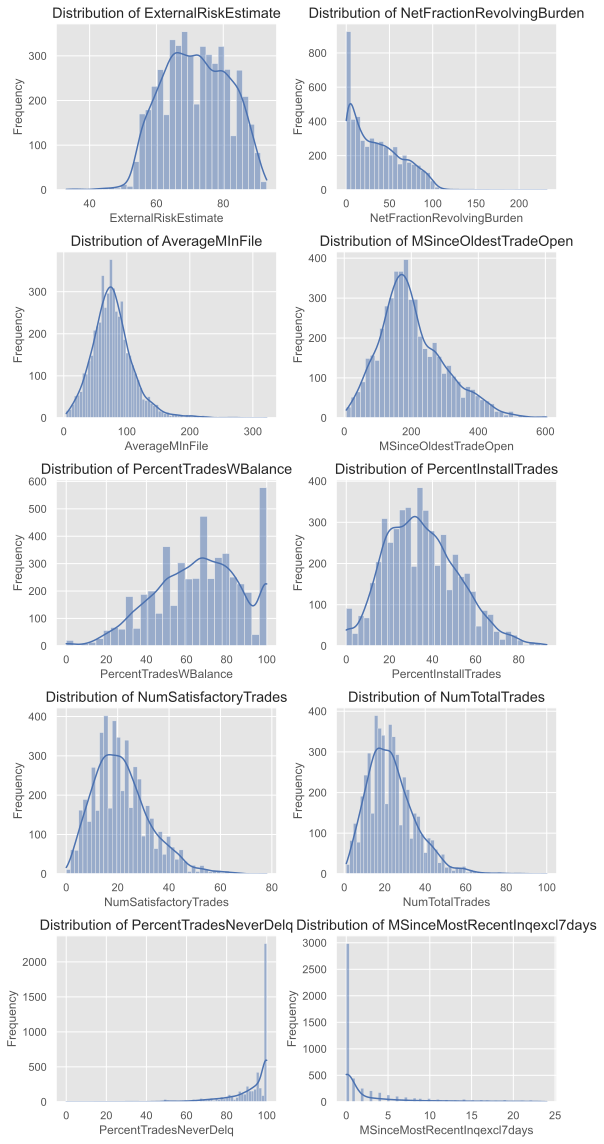

In [8]:
# Function for plotting histograms
def plot_distributions(df_cleaned_cleaned, columns):

    '''
    Function that creates histograms of the different variables found in the dataset.
    '''
    
    n = len(columns)
    n_cols = 2  # Number of columns of subgraphs
    n_rows = (n + 1) // n_cols  # Number of necessary rows

    plt.figure(figsize=(8, 16)) # Adjust figure size
    for i, column in enumerate(columns):
        plt.subplot(n_rows, n_cols, i + 1)  # Creates subgraphs
        sns.histplot(df_cleaned_cleaned[column], kde=True)  # KDE = smooth density curve
        plt.title(f'Distribution of {column}')
        plt.xlabel(column)
        plt.ylabel('Frequency')

    plt.tight_layout()  # Adjust subgraphs so that they do not overlap
    plt.show()

# Plot distributions for numerical variables
numerical_columns = df_cleaned.select_dtypes(include=['int64', 'float64']).columns  # Gets variables names columns
plot_distributions(df_cleaned, numerical_columns)

#### Box-plots

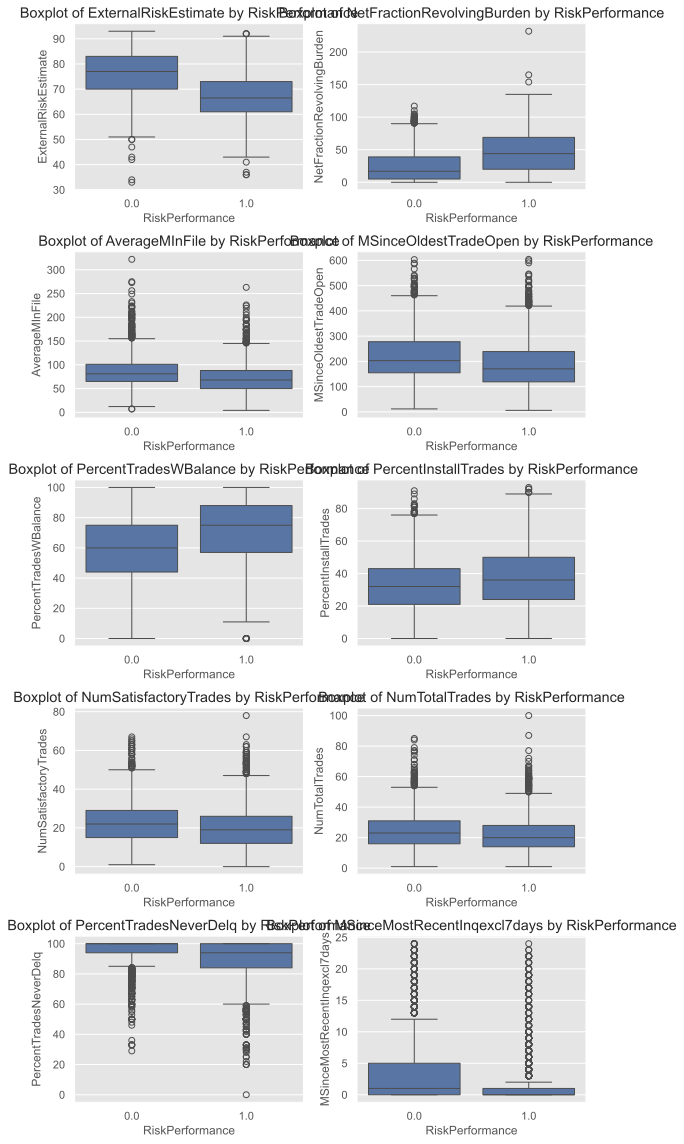

In [9]:
# Function for making boxplots
def plot_boxplots(df_cleaned, columns):

    '''
    Function that creates boxplots of the different variables found in the dataset.
    '''
    
    n = len(columns)
    n_cols = 2  # Number of columns of subgraphs
    n_rows = (n + 1) // n_cols  # Number of necessary rows

    plt.figure(figsize=(8, 16)) # Adjust figure size
    for i, column in enumerate(columns):
        plt.subplot(n_rows, n_cols, i + 1)  # Creates subgraphs
        sns.boxplot(x='RiskPerformance', y=column, data=df_cleaned)
        plt.title(f'Boxplot of {column} by RiskPerformance')

    plt.tight_layout()  # Adjust subgraphs so that they do not overlap
    plt.show()

# Boxplots for numerical variables by RiskPerformance
#print(numerical_columns)
plot_boxplots(df_cleaned, numerical_columns)

#### Q-Q plots

In [ ]:
def plot_qqplots(df_cleaned, columns):
    '''
    Function that creates Q-Q plots of the different variables found in the dataset.
    '''
    
    n = len(columns)
    n_cols = 2 # Number of columns of subgraphs
    n_rows = (n + 1) // n_cols  # Number of necessary rows

    plt.figure(figsize=(8, 16))  # Adjust figure size
    for i, column in enumerate(columns):
        plt.subplot(n_rows, n_cols, i + 1)  # Creates subgraphs
        sm.qqplot(df_cleaned[column], line='s', ax=plt.gca())
        plt.title(f'Q-Q Plot of {column}') 

    plt.tight_layout()  # Adjust subgraphs so that they do not overlap
    plt.show()



# Q-Q plots for numerical variables
plot_qqplots(df_cleaned, numerical_columns)

We can see that there are some outliers (theoretically), but if we analize the meaning of every varible, the large number of outliers has sense, so we aren't going to eliminate them from the dataset. In fact, that 'outliers' are not because values are not normalized. 

### **1.5 Exploratory Data Analysis (EDA)**

#### Summary functions

In [ ]:
df_cleaned.describe()

#### Matrix correlation

In [ ]:
def plot_correlation_heatmap(df_cleaned):
    '''
    Function for plotting the correlation matrix
    '''
    plt.figure(figsize=(10, 10))
    corr = df_cleaned.corr()  # Get the correlation matrix
    mask = np.triu(np.ones_like(corr, dtype=bool))  # Omit the same correlationd (diagonal + upper triangle)
    sns.heatmap(corr, mask=mask, annot=True, cmap='coolwarm', linewidths=0.5, fmt='.2f', square=True)  # Heat map
    plt.title('Correlation Heatmap')
    plt.show()

# Correlation heatmap
plot_correlation_heatmap(df_cleaned) # Pairplot with hue on RiskPerformance

#### Pairplots

In [ ]:
sns.pairplot(df_cleaned, hue='RiskPerformance', vars=numerical_columns[:3], height=2.5)
plt.show()

---

#### More Preprocessing

In [ ]:
# Prepare data for modeling
X = df_cleaned.drop('RiskPerformance', axis=1) # axis = 1 for column
INPUTS = X.columns.tolist()  # Convert to dictionary

# Change all inputs in integers
X = X.astype('int64')
print('INPUTS: ', INPUTS)
print("\nX values info: \n")
print(X.info())

y = df_cleaned['RiskPerformance']  # Get output

In [ ]:
# Plots variances of variables
def plot_variance(X):
    
    variance = X.var()
    plt.figure(figsize=(12, 6))
    sns.barplot(x=variance.index, y=variance.values)
    plt.title('Variance of characteristics')
    plt.xticks(rotation=45)
    plt.show()
    
plot_variance(X)

In [ ]:
# Feature selection
def chi_square_feature_selection(X, y, alpha=0.05):
    """
    Select important features using the Chi-squared test.
    
    Args:
      X: DataFrame, features.
      y: Target variable.
      alpha: float, significance level for filtering features (default is 0.05).
    
    Returns:
      important_features: DataFrame, significant features based on Chi-squared.
    """
    # Calculate Chi-squared values and p-values
    chi2_values, p_values = chi2(X, y)
    
    # Create DataFrame with results
    chi2_results = pd.DataFrame({
        'Feature': X.columns,
        'Chi2 Value': chi2_values,
        'p-value': p_values
    })
    
    # Filter features with p-value < alpha
    important_features = chi2_results[chi2_results['p-value'] < alpha]['Feature']
    
    print("Important features according to Chi-squared:")
    print(important_features)
    
    return important_features

important_chi2_features = chi_square_feature_selection(X, y, alpha = 0.05)

In [ ]:
# Feature Selection
def mutual_information_feature_selection(X, y, threshold=0.1):
    """
    Select important features using Mutual Information.
    
    Args:
      X: DataFrame, features.
      y: Target variable.
      threshold: float, threshold for filtering features based on Mutual Information (default is 0.1).
    
    Returns:
      important_features: Index, significant features based on Mutual Information.
    """
    # Calculate Mutual Information
    mi = mutual_info_classif(X, y)
    
    # Create a Series with results sorted in descending order
    mi_results = pd.Series(mi, index=X.columns).sort_values(ascending=False)
    
    # Filter features with Mutual Information greater than the threshold
    important_features = mi_results[mi_results > threshold].index
    
    print("Important features according to Mutual Information:")
    print(important_features)
    
    return important_features

important_mi_features = mutual_information_feature_selection(X, y, threshold=0.1)

In [ ]:
# Feature Selection
def perform_pca(X, variance_threshold=0.95):
    """
    Perform Principal Component Analysis (PCA) on the dataset and select important features.
    
    Parameters:
    - X: DataFrame, features.
    - variance_threshold: float, threshold for the amount of variance to retain (default is 0.95).
    
    Returns:
    - important_features: List of important features that contribute to the principal components.
    """
    # Scale the features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # Perform PCA
    pca = PCA(n_components=variance_threshold)
    pca.fit_transform(X_scaled)

    # Get loadings (components)
    loadings = pca.components_

    # Get the importance of each feature by checking the absolute value of loadings
    feature_importances = pd.DataFrame(loadings, columns=X.columns)
    
    # Select features that contribute the most to each component (for simplicity, use the first component)
    top_features = feature_importances.iloc[0].abs().sort_values(ascending=False)
    
    # Choose a cutoff or simply take all features that contribute significantly (e.g., top N or based on a threshold)
    important_features = top_features[top_features > 0.1].index.tolist()  # Adjust the threshold as needed

    # Show results
    print(f"Original number of features: {X.shape[1]}")
    print(f"Number of features selected: {len(important_features)}")
    print(f"Important features selected: {important_features}")
    
    return important_features

# Perform PCA and select important features
important_features = perform_pca(X)

___

### **1.6 Check for class imbalances**

In [ ]:
# Output class count
print(df_cleaned['RiskPerformance'].value_counts())
print(df_cleaned['RiskPerformance'].value_counts(normalize=True))
#print(f'Difference between class proportion: {}')

plt.figure(figsize=(8, 4))
df_cleaned['RiskPerformance'].value_counts().plot(kind='bar')
plt.title('Distribution of RiskPerformance')
plt.xlabel('RiskPerformance')
plt.ylabel('Count')
plt.show()

We see that outpust values are balanced.

### **1.7 Split data in train and test**

#### **Parameter selection from terminal**

In [ ]:
# Introduce some parameters

CV_check = input('\n Do you want to do Cross Validation (train models with various hyperparameters)? \n YES \n NO \n')

### Parameter to maximice in Cross Validation
score = input("\n Choose a parameter (only one) to maximice in Cross Validation: \n"
      " accuracy \n"
      " f1 \n"
      " precision \n"
      " recall \n"
      " roc_auc \n")

### Inputs to train the models
selected_inputs_values = input("Choose input variables to train models separated by spaces (example: 1 3 4 5): \n"
      " 0. ALL INPUTS \n"
      " 1. ExternalRiskEstimate \n"
      " 2. NetFractionRevolvingBurden \n"
      " 3. AverageMInFile \n"
      " 4. MSinceOldestTradeOpen \n"
      " 5. PercentTradesWBalance \n"
      " 6. PercentInstallTrades \n"
      " 7. NumSatisfactoryTrades \n"
      " 8. NumTotalTrades \n"
      " 9. PercentTradesNeverDelq \n"
      "10. MSinceMostRecentInqexcl7days \n")

# Convertimos la cadena ingresada en una lista 
selected_inputs_index = list(map(int, selected_inputs_values.split()))

## Calculate new inputs list 

# Establish inpust constant for running again
INPUTS = X.columns.tolist()  # Convert to dictionary

# In case we want to use all inputs
if (0 in selected_inputs_index):
    INPUTS = INPUTS

# In case we don't want to use all inputs
else:    
    selected_inputs_index = [i - 1 for i in selected_inputs_index]

    inputs_index_list = list(range(len(INPUTS)))
    print(INPUTS)

    # Filtramos los índices seleccionados y eliminamos los que no estén en el rango
    selected_inputs_index = [index for index in selected_inputs_index if index in inputs_index_list]

    # Obtenemos los inputs seleccionados
    INPUTS = [INPUTS[index] for index in selected_inputs_index]

# Mostramos los inputs seleccionados
print(" \n Selected inputs: \n \n", INPUTS)

# Create directory to save graphs and csv's 
path = f'{score}CV_{NA_check}missing_YESoutliers_{selected_inputs_values}variables'
os.makedirs(path, exist_ok=True)
                # exist_ok=True --> if dyrectory exist, no create a duplicate one

In [ ]:
# Prepare data for modeling
X = df_cleaned[INPUTS]

# Change all inputs in integers
#X = X.astype('int64')
print('INPUTS: ', INPUTS)
print("\nX values info: \n")
print(X.info())

y = df_cleaned['RiskPerformance']  # Get output

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y,            # Inputs and outputs
                                                    test_size=0.2,   # Percentage of test data
                                                    random_state=42, # Seed for replication
                                                    stratify=y)      # Preserves distribution of y

In [ ]:
X_train.head()

In [ ]:
y_train

In [25]:
# Create dataset to store model predictions
dfTR_eval = X_train.copy()
dfTR_eval['RiskPerformance'] = y_train # We will call Y as output variable for simplicity

dfTS_eval = X_test.copy()
dfTS_eval['RiskPerformance'] = y_test # We will call Y as output variable for simplicity

In [ ]:
# Pairplots of train and test data
sns.pairplot(dfTR_eval, hue='RiskPerformance', vars=numerical_columns[:3], height=2.5)
plt.suptitle("Training set", y=1.02) 
plt.show()

sns.pairplot(dfTS_eval, hue='RiskPerformance', vars=numerical_columns[:3], height=2.5)
plt.suptitle("Test set", y=1.02) 
plt.show()

___

<br><br><br>

___

## **2. Identification and fitting process of classification models**

### **2.1 Logistic Regression (LR)**

In [ ]:
INPUTS_LR = INPUTS
#print(INPUTS_LR)

LogReg_fit = Pipeline(steps=[('scaler',StandardScaler()), # Preprocess the variables when training the model, 
                             # z = x - mean(x) / std(x). This results in a normal distribution (mean=0, variance=1)
                        ('LogReg',LogisticRegression(penalty=None))]) # Model to use in the pipeline
                             # Penalty is the penalty applied during model optimization to avoid overfitting.
                             # Options are: L1 (Lasso), L2 (Ridge) and elasticnet (comb of L1 and L2).

# Train model
LogReg_fit.fit(X_train[INPUTS_LR], y_train)
print("Logistic Regression Trained")
LogReg_fit  # Visualization

# Obtain Cross-Validation score, the result is the accuracy of the model we want to expect.

# We focus on increasing the precision, because we want to reduce the false positive rate.

cv_acc_LR = cross_val_score(LogReg_fit, X_train[INPUTS_LR], y_train, cv=10, scoring=score).mean()
print(f"CV accuracy is: {cv_acc_LR:.5f}")


# Accuracy: correct predictions / total prediction     
# Precision: TP / (TP + FP)

In [ ]:
## Obtain a report of the model based on predictions ---------------------------------------------
dfTR_eval['Y_LR_pred'] = LogReg_fit.predict(X_train[INPUTS_LR])

### Scale test using preprocess in training
dfTS_eval['Y_LR_pred'] = LogReg_fit.predict(X_test[INPUTS_LR])

#visualize evaluated data
dfTR_eval.head()

In [ ]:
#Confusion matrix for Log Reg Model
print("----- TRAINING CONFUSION MATRIX -----")
acc_LR_train, sens_LR_train, spec_LR_train, precision_LR_train, F_score_LR_train = confusion_matrix(y_train, dfTR_eval['Y_LR_pred'],labels=[0,1])

In [ ]:
print("----- TEST CONFUSION MATRIX-----")
acc_LR_test, sens_LR_test, spec_LR_test, precision_LR_test, F_score_LR_test = confusion_matrix(y_test, dfTS_eval['Y_LR_pred'],labels=[0,1])

In [ ]:
plotClassPerformance(path, y_test, LogReg_fit.predict_proba(X_test[INPUTS_LR]), selClass=1, model_name='LR')

In [32]:
## We save important values from LG model

models = ['LR','KNN','DT','RF','SVM','GBC','NB','MLP']

# Cross validation
models_result_CV_dict = {
    str(score): np.zeros(len(models)),
}
models_result_CV_dict[str(score)][models.index('LR')] = cv_acc_LR


# Train
models_result_train_dict = {
    'accuracy': np.zeros(len(models)),
    'sensitivity': np.zeros(len(models)),
    'specificity': np.zeros(len(models)),
    'precision': np.zeros(len(models)),
    'f1_score': np.zeros(len(models))
}
models_result_train_dict['accuracy'][models.index('LR')] = acc_LR_train 
models_result_train_dict['sensitivity'][models.index('LR')] = sens_LR_train
models_result_train_dict['specificity'][models.index('LR')] = spec_LR_train
models_result_train_dict['precision'][models.index('LR')] = precision_LR_train
models_result_train_dict['f1_score'][models.index('LR')] = F_score_LR_train


# Test
models_result_test_dict = {
    'accuracy': np.zeros(len(models)),
    'sensitivity': np.zeros(len(models)),
    'specificity': np.zeros(len(models)),
    'precision': np.zeros(len(models)),
    'f1_score': np.zeros(len(models))
}

models_result_test_dict['accuracy'][models.index('LR')] = acc_LR_test
models_result_test_dict['sensitivity'][models.index('LR')] = sens_LR_test
models_result_test_dict['specificity'][models.index('LR')] = spec_LR_test
models_result_test_dict['precision'][models.index('LR')] = precision_LR_test
models_result_test_dict['f1_score'][models.index('LR')] = F_score_LR_test

#print(models_result_CV_dict)
#print(models_result_train_dict)
#print(models_result_test_dict)

___

### **2.2 K-Nearest Neighbors (KNN)**

In [ ]:
INPUTS_KNN = INPUTS  # Change inputs to KNN Model
#print(INPUTS_KNN)

# Configure model and hyparameter tuning
if CV_check == 'YES':
    param = {'knn__n_neighbors': range(3,500,4)}  # Number of neighbors, we try a list of posible number neighbors
else:
    param = {'knn__n_neighbors': [155]}  # In case we want 1 param

# Scale data previous to fit
pipe = Pipeline(steps=[('scaler', StandardScaler()), ('knn', KNeighborsClassifier())])

# We use Grid Search Cross Validation to find the best parameter for the model in the grid defined 
nFolds = 10
knn_fit = GridSearchCV(estimator=pipe,      # Structure of the model to use (scaled + classification)
                        param_grid=param,   # Defined grid to search in [dictionary]
                        n_jobs=-1,          # Number of cores to use (parallelize)
                        scoring=score, # Evaluation metric to be optimised
                        cv=nFolds)          # Number of Folds 

knn_fit.fit(X_train[INPUTS_KNN], y_train) 

# Obtain the best parameters
best_params_KNN = knn_fit.best_params_

# Obtain the best score
best_score_KNN = knn_fit.best_score_

print("Best parameters:", best_params_KNN)
print("Best score:", best_score_KNN)

print("kNN Trained")

In [ ]:
# Obtain Cross-Validation score, the result is the accuracy of the model we want to expect.

# We focus on increasing the precision, because we want to reduce the false positive rate.

cv_acc_KNN = cross_val_score(knn_fit, X_train, y_train, cv=10, scoring=score).mean()
print(f"CV accuracy is: {cv_acc_KNN:.5f}")


# Accuracy: correct predictions / total prediction
# Precision: TP / (TP + FP)

In [ ]:
plotModelGridError(knn_fit)

In [36]:
## Obtain a report of the model based on predictions ---------------------------------------------
dfTR_eval['Y_KNN_pred'] = knn_fit.predict(X_train[INPUTS_KNN])
dfTR_eval['Y_KNN_prob_neg'] = knn_fit.predict_proba(X_train[INPUTS_KNN])[:,0]
dfTR_eval['Y_KNN_prob_pos'] = knn_fit.predict_proba(X_train[INPUTS_KNN])[:,1]
### Scale test using preprocess in training
dfTS_eval['Y_KNN_pred'] = knn_fit.predict(X_test[INPUTS_KNN])
dfTS_eval['Y_KNN_prob_neg'] = knn_fit.predict_proba(X_test[INPUTS_KNN])[:,0]
dfTS_eval['Y_KNN_prob_pos'] = knn_fit.predict_proba(X_test[INPUTS_KNN])[:,1]

In [ ]:
dfTR_eval.head()

In [ ]:
dfTS_eval.head()

We check that new variables are created.

In [ ]:
acc_KNN_train, sens_KNN_train, spec_KNN_train, precision_KNN_train, F_score_KNN_train = confusion_matrix(y_train, dfTR_eval['Y_KNN_pred'], labels=[0,1])

In [ ]:
acc_KNN_test, sens_KNN_test, spec_KNN_test, precision_KNN_test, F_score_KNN_test = confusion_matrix(y_test, dfTS_eval['Y_KNN_pred'], labels=[0,1])

In [ ]:
plotClassPerformance(path, y_test, knn_fit.predict_proba(X_test[INPUTS_KNN]), selClass=1, model_name='KNN')

In [42]:
# We save important values from LG model

# Cross validation

models_result_CV_dict[str(score)][models.index('KNN')] = cv_acc_KNN

# Train
models_result_train_dict['accuracy'][models.index('KNN')] = acc_KNN_train 
models_result_train_dict['sensitivity'][models.index('KNN')] = sens_KNN_train
models_result_train_dict['specificity'][models.index('KNN')] = spec_KNN_train
models_result_train_dict['precision'][models.index('KNN')] = precision_KNN_train
models_result_train_dict['f1_score'][models.index('KNN')] = F_score_KNN_train

# Test
models_result_test_dict['accuracy'][models.index('KNN')] = acc_KNN_test
models_result_test_dict['sensitivity'][models.index('KNN')] = sens_KNN_test
models_result_test_dict['specificity'][models.index('KNN')] = spec_KNN_test
models_result_test_dict['precision'][models.index('KNN')] = precision_KNN_test
models_result_test_dict['f1_score'][models.index('KNN')] = F_score_KNN_test

#print(models_result_CV_dict)
#print(models_result_train_dict)
#print(models_result_test_dict)

___

### **2.3 Decision Trees (DT)**

In [ ]:
## Decision Tree
# Inputs of the model
INPUTS_DT = INPUTS
#print(INPUTS_DT)

## Model training

# Hyperparameters to try in Cross Validation
if CV_check == 'YES':
    param = {'DT__min_impurity_decrease': np.arange(0,0.05,0.0005)} # Minimum gini to decrease in each split
    
else: 
    param = {'DT__min_impurity_decrease': [0.001]} # Minimum gini to decrease in each split

# Pipeline
pipe = Pipeline(steps=[('scaler', StandardScaler()), # Data reescaling
                       ('DT', DecisionTreeClassifier(criterion='gini',  # impurity measure
                                                     min_samples_split=5, # Minimum number of obs in node to keep cutting
                                                     min_samples_leaf=5, # Minimum number of obs in a terminal node
                                                     random_state=150))]) # For replication

# We use Grid Search Cross Validation to find the best parameter for the model in the grid defined 
nFolds = 10
tree_fit = GridSearchCV(estimator=pipe, # Structure of the model to use
                       param_grid=param, # Defined grid to search in
                       n_jobs=-1, # Number of cores to use (parallelize)
                       #scoring=score, # Accuracy https://scikit-learn.org/stable/modules/model_evaluation.html
                       cv=nFolds) # Number of Folds 

# Fit of the model
tree_fit.fit(X_train[INPUTS_DT], y_train) # Search in grid

# Obtain the best parameters
best_params_DT = tree_fit.best_params_

# Obtain the best score
best_score_DT = tree_fit.best_score_

print("Best parameters:", best_params_DT)
print("Best score:", best_score_DT)

print("Decision Tree Trained")

In [ ]:
# Cross validation
cv_acc_DT = cross_val_score(tree_fit, X_train[INPUTS_DT], y_train, cv=10, scoring=score).mean()
print(f"CV accuracy is: {cv_acc_DT:.5f}")

In [112]:
plotModelGridError(tree_fit, figsize=(8, 4))

In [ ]:
# Plot the variable importance of each feature
plt.figure(figsize=(6 * 1.618, 6))
index = np.arange(len(X_train[INPUTS_DT].columns))
bar_width = 0.35
plt.bar(index, tree_fit.best_estimator_['DT'].feature_importances_, color='black', alpha=0.5)
plt.xlabel('features')
plt.xticks(index, X_train[INPUTS_DT].columns, rotation=45, ha='right')
plt.ylabel('importance')
plt.ylim(0, 1)
plt.title('Feature importance')
plt.xticks(index, X_train[INPUTS_DT].columns)
plt.tight_layout()
plt.show()

In [ ]:
# Obtain predictions from trainning data
dfTR_eval['Y_DT_pred'] = tree_fit.predict(X_train[INPUTS_DT])
dfTR_eval['Y_DT_prob_neg'] = tree_fit.predict_proba(X_train[INPUTS_DT])[:,0]
dfTR_eval['Y_DT_prob_pos'] = tree_fit.predict_proba(X_train[INPUTS_DT])[:,1]

# Obtain predictions from test data
dfTS_eval['Y_DT_pred'] = tree_fit.predict(X_test[INPUTS_DT])
dfTR_eval['Y_DT_prob_neg'] = tree_fit.predict_proba(X_train[INPUTS_DT])[:,0]
dfTR_eval['Y_DT_prob_pos'] = tree_fit.predict_proba(X_train[INPUTS_DT])[:,1]

# Visualize evaluated data
dfTR_eval.head()

In [ ]:
# Confusion matrix of the train data
acc_DT_train, sens_DT_train, spec_DT_train, precision_DT_train, F_score_DT_train = confusion_matrix(y_train, dfTR_eval['Y_DT_pred'], labels=[0,1])

In [ ]:
# Confusion matrix of the test data
acc_DT_test, sens_DT_test, spec_DT_test, precision_DT_test, F_score_DT_test = confusion_matrix(y_test, dfTS_eval['Y_DT_pred'], labels=[0,1])

As change in accuracy between trainning and test data is around 2%, we can conclude that there's no overfitting.

In [ ]:
# Plots for checking model quality with test data
plotClassPerformance(path, y_test, tree_fit.predict_proba(X_test[INPUTS_DT]), selClass=1.0, model_name='DT')

In [ ]:
# Plot the decision tree model
plt.figure(figsize=(12, 12))
plot_tree(tree_fit.best_estimator_['DT'], filled=True, feature_names=INPUTS)
plt.savefig("decision_tree_plot.png", format='png', dpi=300, bbox_inches='tight') # Save image
plt.show()

In [52]:
# We save important values from DT model

# Cross validation

models_result_CV_dict[str(score)][models.index('DT')] = cv_acc_DT

# Train
models_result_train_dict['accuracy'][models.index('DT')] = acc_DT_train 
models_result_train_dict['sensitivity'][models.index('DT')] = sens_DT_train
models_result_train_dict['specificity'][models.index('DT')] = spec_DT_train
models_result_train_dict['precision'][models.index('DT')] = precision_DT_train
models_result_train_dict['f1_score'][models.index('DT')] = F_score_DT_train

# Test
models_result_test_dict['accuracy'][models.index('DT')] = acc_DT_test
models_result_test_dict['sensitivity'][models.index('DT')] = sens_DT_test
models_result_test_dict['specificity'][models.index('DT')] = spec_DT_test
models_result_test_dict['precision'][models.index('DT')] = precision_DT_test
models_result_test_dict['f1_score'][models.index('DT')] = F_score_DT_test

#print(models_result_CV_dict)
#print(models_result_train_dict)
#print(models_result_test_dict)

___

### **2.4 Random Forest (RF)**

In [ ]:
## Inputs of the model. Change accordingly to perform variable selection
INPUTS_RF = INPUTS
#print(INPUTS_RF)

# Hyperparameters to try in Cross Validation
if CV_check == 'YES':
    param = {'RF__n_estimators': range(10, 300, 10),     # Number of trees
             'RF__max_depth': [2, 5, 10, 20, 30]}        # Depth of trees
else: 
    param = {'RF__n_estimators': [160],     # Number of trees
             'RF__max_depth': [2]}  # Depth of trees
    
# Pipeline
pipe = Pipeline(steps=[('scaler', StandardScaler()), 
                       ('RF', RandomForestClassifier(criterion='gini', # impuriry measure
                                                    max_features=len(X_train.columns),  # number of variables randomly sampled as candidates at each split.
                                                    min_samples_split=5,  # Minimum number of obs in node to keep cutting
                                                    min_samples_leaf=5, # Minimum number of obs in a terminal node
                                                    random_state=150))]) # For replication

# We use Grid Search Cross Validation to find the best parameter for the model in the grid defined 
nFolds = 10
rf_fit = GridSearchCV(estimator=pipe, # Structure of the model to use
                       param_grid=param, # Defined grid to search in
                       n_jobs=-1, # Number of cores to use (parallelize)
                       scoring=score, # Accuracy https://scikit-learn.org/stable/modules/model_evaluation.html
                       cv=nFolds) # Number of Folds 

rf_fit.fit(X_train[INPUTS_RF], y_train) # Search in grid

# Obtain the best parameters
best_params_RF = rf_fit.best_params_

# Obtain the best score
best_score_RF = rf_fit.best_score_

print("Best parameters:", best_params_RF)
print("Best score (accuracy):", best_score_RF)

print("Random Forest Trained")

In [ ]:
# Cross validation
cv_acc_RF = cross_val_score(rf_fit, X_train[INPUTS_DT], y_train, cv=10, scoring=score).mean()
print(f"CV accuracy is: {cv_acc_RF:.5f}")

In [119]:
#plotModelGridError(rf_fit)

In [ ]:
## Plot the variable importance of each feature
plt.figure(figsize=(6 * 1.618, 6))
index = np.arange(len(X_train[INPUTS_RF].columns))
bar_width = 0.35
plt.bar(index, rf_fit.best_estimator_['RF'].feature_importances_, color='black', alpha=0.5)
plt.xlabel('features')
plt.ylabel('importance')
plt.title('Feature importance')
plt.xticks(index, X_train[INPUTS_RF].columns, rotation = 90)
plt.tight_layout()
plt.show()

In [ ]:
## Obtain a report of the model based on predictions ---------------------------------------------
dfTR_eval['Y_RF_pred'] = rf_fit.predict(X_train[INPUTS_RF])
dfTR_eval['Y_RF_prob_neg'] = rf_fit.predict_proba(X_train[INPUTS_RF])[:,0]
dfTR_eval['Y_RF_prob_pos'] = rf_fit.predict_proba(X_train[INPUTS_RF])[:,1]
### Scale test using preprocess in training
dfTS_eval['Y_RF_pred'] = rf_fit.predict(X_test[INPUTS_RF])
dfTS_eval['Y_RF_prob_neg'] = rf_fit.predict_proba(X_test[INPUTS_RF])[:,0]
dfTS_eval['Y_RF_prob_pos'] = rf_fit.predict_proba(X_test[INPUTS_RF])[:,1]

dfTR_eval.head()

In [ ]:
acc_RF_train, sens_RF_train, spec_RF_train, precision_RF_train, F_score_RF_train = confusion_matrix(y_train, dfTR_eval['Y_RF_pred'], labels=[0,1])

In [ ]:
acc_RF_test, sens_RF_test, spec_RF_test, precision_RF_test, F_score_RF_test = confusion_matrix(y_test, dfTS_eval['Y_RF_pred'], labels=[0,1])

In [ ]:
plotClassPerformance(path, y_test, rf_fit.predict_proba(X_test[INPUTS_RF]), selClass=1.0, model_name='RF')

In [61]:
# We save important values from RF model

# Cross validation

models_result_CV_dict[str(score)][models.index('RF')] = cv_acc_RF


# Train
models_result_train_dict['accuracy'][models.index('RF')] = acc_RF_train 
models_result_train_dict['sensitivity'][models.index('RF')] = sens_RF_train
models_result_train_dict['specificity'][models.index('RF')] = spec_RF_train
models_result_train_dict['precision'][models.index('RF')] = precision_RF_train
models_result_train_dict['f1_score'][models.index('RF')] = F_score_RF_train

# Test
models_result_test_dict['accuracy'][models.index('RF')] = acc_RF_test
models_result_test_dict['sensitivity'][models.index('RF')] = sens_RF_test
models_result_test_dict['specificity'][models.index('RF')] = spec_RF_test
models_result_test_dict['precision'][models.index('RF')] = precision_RF_test
models_result_test_dict['f1_score'][models.index('RF')] = F_score_RF_test

#print(models_result_CV_dict)
#print(models_result_train_dict)
#print(models_result_test_dict)

___

### **2.5 Support Vector Machines (SVM)**

In [ ]:
## Inputs of the model
INPUTS_LSVC = INPUTS
#print(INPUTS_LSVC)

# Hyperparameters to try in Cross Validation
if CV_check == 'YES':
    param = {'SVC__C': [0.00001,0.0001,0.001,0.01,0.1,1,10]} # Cost term
    
else: 
    param = {'SVC__C': [0.01]} # Cost term

# Pipeline
pipe = Pipeline(steps=[ ('scaler', StandardScaler()), 
                        ('SVC',  SVC(kernel='linear', # lineal kernel
                                    probability=True, # let the model predict probabilities
                                    random_state=150))]) # For replication


# We use Grid Search Cross Validation to find the best parameter for the model in the grid defined 
nFolds = 5
Linear_SVC_gcv = GridSearchCV(estimator=pipe, # Structure of the model to use
                        param_grid=param, # Defined grid to search in
                        n_jobs=-1, # Number of cores to use (parallelize)
                        scoring=score, # Accuracy https://scikit-learn.org/stable/modules/model_evaluation.html
                        cv=nFolds) # Number of Folds 
Linear_SVC_gcv.fit(X_train[INPUTS_LSVC], y_train) # Search in grid

# Obtain the best parameters
best_params_LSVC = Linear_SVC_gcv.best_params_

# Obtain the best score
best_score_LSVC = Linear_SVC_gcv.best_score_

print("Best parameters:", best_params_LSVC)
print("Best score (accuracy):", best_score_LSVC)

# We use Calibrated CV to transform predictions of the model to probabilities due to a known bug in scikit SVC
Linear_SVC_fit = CalibratedClassifierCV(
                        estimator=Linear_SVC_gcv, # Structure of the model to use
                        n_jobs=-1, # Number of cores to use (parallelize)
                        method='isotonic', # The method to use for calibration
                        cv=nFolds) # Number of Folds 

Linear_SVC_fit.fit(X_train[INPUTS_LSVC], y_train) # Search in grid

print("Linear SVC Trained")


In [ ]:
# Cross validation
cv_acc_SVM = cross_val_score(Linear_SVC_fit, X_train[INPUTS_DT], y_train, cv=10, scoring=score).mean()
print(f"CV accuracy is: {cv_acc_SVM:.5f}")

In [64]:
#plotModelGridError(Linear_SVC_fit.estimator, xscale="log")

In [ ]:
## Plot the variable coefficient of each feature
plt.figure(figsize=(6 * 1.618, 6))
index = np.arange(len(X_train[INPUTS_LSVC].columns))
bar_width = 0.35
plt.bar(index, Linear_SVC_fit.estimator.best_estimator_['SVC'].coef_[0,:], color='black', alpha=0.5)
plt.xlabel('Features')
plt.ylabel('Coefficient')
plt.title('Coefficients of features')
plt.xticks(index, X_train[INPUTS_LSVC].columns, rotation = 90)
plt.tight_layout()
plt.show()

In [ ]:
## Obtain a report of the model based on predictions ---------------------------------------------
dfTR_eval['Y_LSVC_pred'] = Linear_SVC_fit.predict(X_train[INPUTS_LSVC])
dfTR_eval['Y_LSVC_prob_neg'] = Linear_SVC_fit.predict_proba(X_train[INPUTS_LSVC])[:,0]
dfTR_eval['Y_LSVC_prob_pos'] = Linear_SVC_fit.predict_proba(X_train[INPUTS_LSVC])[:,1]
### Scale test using preprocess in training
dfTS_eval['Y_LSVC_pred'] = Linear_SVC_fit.predict(X_test[INPUTS_LSVC])
dfTS_eval['Y_LSVC_prob_neg'] = Linear_SVC_fit.predict_proba(X_test[INPUTS_LSVC])[:,0]
dfTS_eval['Y_LSVC_prob_pos'] = Linear_SVC_fit.predict_proba(X_test[INPUTS_LSVC])[:,1]

#visualize evaluated data
dfTR_eval.head()

In [ ]:
acc_SVM_train, sens_SVM_train, spec_SVM_train, precision_SVM_train, F_score_SVM_train = confusion_matrix(y_train, dfTR_eval['Y_LSVC_pred'], labels=[0,1])

In [ ]:
acc_SVM_test, sens_SVM_test, spec_SVM_test, precision_SVM_test, F_score_SVM_test = confusion_matrix(y_test, dfTS_eval['Y_LSVC_pred'], labels=[0,1])

In [ ]:
plotClassPerformance(path, y_test, Linear_SVC_fit.predict_proba(X_test[INPUTS_LSVC]), selClass=1, model_name='SVM')

In [70]:
# We save important values from SVM model

# Cross validation

models_result_CV_dict[str(score)][models.index('SVM')] = cv_acc_SVM

# Train
models_result_train_dict['accuracy'][models.index('SVM')] = acc_SVM_train 
models_result_train_dict['sensitivity'][models.index('SVM')] = sens_SVM_train
models_result_train_dict['specificity'][models.index('SVM')] = spec_SVM_train
models_result_train_dict['precision'][models.index('SVM')] = precision_SVM_train
models_result_train_dict['f1_score'][models.index('SVM')] = F_score_SVM_train

# Test
models_result_test_dict['accuracy'][models.index('SVM')] = acc_SVM_test
models_result_test_dict['sensitivity'][models.index('SVM')] = sens_SVM_test
models_result_test_dict['specificity'][models.index('SVM')] = spec_SVM_test
models_result_test_dict['precision'][models.index('SVM')] = precision_SVM_test
models_result_test_dict['f1_score'][models.index('SVM')] = F_score_SVM_test

#print(models_result_CV_dict)
#print(models_result_train_dict)
#print(models_result_test_dict)

___

### **2.6 Gradient Boosting Classifier (GBC)**

In [ ]:
# Inputs del modelo
INPUTS_GB = INPUTS
#print(INPUTS_GB)

# Hyperparameters to try in Cross Validation
if CV_check == 'YES':
    param_gb = {'GB__n_estimators': range(10, 100, 5),   # Número de árboles
                'GB__learning_rate': [0.01, 0.05, 0.1],       # Tasa de aprendizaje
                'GB__max_depth': [3, 5, 10]}                 # Profundidad máxima de los árboles

else: 
    param_gb = {'GB__n_estimators': [10], 
                'GB__learning_rate': [0.1], 
                'GB__max_depth': [3]}

# Pipeline
pipe_gb = Pipeline(steps=[('scaler', StandardScaler()), 
                          ('GB', GradientBoostingClassifier(random_state=150))])

nFolds = 10
gb_fit = GridSearchCV(estimator=pipe_gb,
                      param_grid=param_gb,
                      n_jobs=-1,
                      scoring=score,
                      cv=nFolds)

gb_fit.fit(X_train[INPUTS_GB], y_train)

# Obtener los mejores parámetros y la mejor puntuación
best_params_GB = gb_fit.best_params_
best_score_GB = gb_fit.best_score_

print("Best parameters (GB):", best_params_GB)
print("Best score (accuracy) (GB):", best_score_GB)


In [ ]:
# Cross validation
cv_acc_GBC = cross_val_score(gb_fit, X_train[INPUTS_DT], y_train, cv=10, scoring=score).mean()
print(f"CV accuracy is: {cv_acc_GBC:.5f}")

In [73]:
#plotModelGridError(gb_fit)

In [ ]:
## Plot the variable importance of each feature
plt.figure(figsize=(6 * 1.618, 6))
index = np.arange(len(X_train[INPUTS_GB].columns))
bar_width = 0.35
plt.bar(index, gb_fit.best_estimator_['GB'].feature_importances_, color='black', alpha=0.5)
plt.xlabel('features')
plt.ylabel('importance')
plt.title('Feature importance')
plt.xticks(index, X_train[INPUTS_GB].columns, rotation = 90)
plt.tight_layout()
plt.show()

In [ ]:
## Obtain a report of the model based on predictions ---------------------------------------------
dfTR_eval['Y_GB_pred'] = gb_fit.predict(X_train[INPUTS_GB])
dfTR_eval['Y_GB_prob_neg'] = gb_fit.predict_proba(X_train[INPUTS_GB])[:,0]
dfTR_eval['Y_GB_prob_pos'] = gb_fit.predict_proba(X_train[INPUTS_GB])[:,1]
### Scale test using preprocess in training
dfTS_eval['Y_GB_pred'] = gb_fit.predict(X_test[INPUTS_GB])
dfTS_eval['Y_GB_prob_neg'] = gb_fit.predict_proba(X_test[INPUTS_GB])[:,0]
dfTS_eval['Y_GB_prob_pos'] = gb_fit.predict_proba(X_test[INPUTS_GB])[:,1]

dfTR_eval.head()

In [ ]:
print("----- TRAIN CONFUSION MATRIX-----")
acc_GBC_train, sens_GBC_train, spec_GBC_train, precision_GBC_train, F_score_GBC_train = confusion_matrix(y_train, dfTR_eval['Y_GB_pred'], labels=[0, 1])

In [ ]:
print("----- TEST CONFUSION MATRIX-----")
acc_GBC_test, sens_GBC_test, spec_GBC_test, precision_GBC_test, F_score_GBC_test = confusion_matrix(y_test, dfTS_eval['Y_GB_pred'], labels=[0, 1])

Accuracy TRAIN: 0.73
Accuracy TEST: 0.71

In [ ]:
plotClassPerformance(path, y_test, gb_fit.predict_proba(X_test[INPUTS_GB]), selClass=1.0, model_name='GBC')

In [79]:
# We save important values from GBC model

# Cross validation

models_result_CV_dict[str(score)][models.index('GBC')] = cv_acc_GBC

# Train
models_result_train_dict['accuracy'][models.index('GBC')] = acc_GBC_train 
models_result_train_dict['sensitivity'][models.index('GBC')] = sens_GBC_train
models_result_train_dict['specificity'][models.index('GBC')] = spec_GBC_train
models_result_train_dict['precision'][models.index('GBC')] = precision_GBC_train
models_result_train_dict['f1_score'][models.index('GBC')] = F_score_GBC_train

# Test
models_result_test_dict['accuracy'][models.index('GBC')] = acc_GBC_test
models_result_test_dict['sensitivity'][models.index('GBC')] = sens_GBC_test
models_result_test_dict['specificity'][models.index('GBC')] = spec_GBC_test
models_result_test_dict['precision'][models.index('GBC')] = precision_GBC_test
models_result_test_dict['f1_score'][models.index('GBC')] = F_score_GBC_test

#print(models_result_CV_dict)
#print(models_result_train_dict)
#print(models_result_test_dict)

___

### **2.7 Navie Bayes (NB)**

In [ ]:
# Inputs del modelo
INPUTS_NB = INPUTS
#print(INPUTS_NB)

nb_pipeline = Pipeline(steps=[
    ('scaler', StandardScaler()),
    ('nb_model', GaussianNB())
])

nb_pipeline.fit(X_train[INPUTS_NB], y_train)

In [ ]:

cv_acc_NB = cross_val_score(nb_pipeline, X_train[INPUTS_NB], y_train, cv=10, scoring=score).mean()
print(f"CV accuracy is: {cv_acc_NB:.5f}")


In [ ]:
dfTR_eval['Y_NB_pred'] = nb_pipeline.predict(X_train[INPUTS_NB])

dfTS_eval['Y_NB_pred'] = nb_pipeline.predict(X_test[INPUTS_NB])

dfTS_eval.head()

In [ ]:
print("----- TRAIN CONFUSION MATRIX-----")
acc_NB_train, sens_NB_train, spec_NB_train, precision_NB_train, F_score_NB_train = confusion_matrix(y_train, dfTR_eval['Y_NB_pred'], labels=[0, 1])

In [ ]:
print("----- TEST CONFUSION MATRIX-----")
acc_NB_test, sens_NB_test, spec_NB_test, precision_NB_test, F_score_NB_test = confusion_matrix(y_test, dfTS_eval['Y_NB_pred'], labels=[0, 1])

In [ ]:
plotClassPerformance(path, y_test, nb_pipeline.predict_proba(X_test[INPUTS_NB]), selClass=1, model_name='NB')

In [86]:
# We save important values from NB model

# Cross validation

models_result_CV_dict[str(score)][models.index('NB')] = cv_acc_NB

# Train
models_result_train_dict['accuracy'][models.index('NB')] = acc_NB_train 
models_result_train_dict['sensitivity'][models.index('NB')] = sens_NB_train
models_result_train_dict['specificity'][models.index('NB')] = spec_NB_train
models_result_train_dict['precision'][models.index('NB')] = precision_NB_train
models_result_train_dict['f1_score'][models.index('NB')] = F_score_NB_train

# Test
models_result_test_dict['accuracy'][models.index('NB')] = acc_NB_test
models_result_test_dict['sensitivity'][models.index('NB')] = sens_NB_test
models_result_test_dict['specificity'][models.index('NB')] = spec_NB_test
models_result_test_dict['precision'][models.index('NB')] = precision_NB_test
models_result_test_dict['f1_score'][models.index('NB')] = F_score_NB_test

#print(models_result_CV_dict)
#print(models_result_train_dict)
#print(models_result_test_dict)

---

### **2.8 Multi-Layer Perceptron (MLP)**

NOTE: Hyperparameters are adapted for 'lbfgs' optimization algorithm. 
The default solver ‘adam’ works pretty well on relatively large datasets (with thousands of training samples or more) in terms of both training time and validation score. For small datasets, however, ‘lbfgs’ can converge faster and perform better.

In [ ]:
#-------------------------------------------------------------------------------------------------
#------------------------------- MLP Class MODEL -------------------------------------------------
#-------------------------------------------------------------------------------------------------
## Inputs of the model. Change accordingly to perform variable selection
INPUTS_MLP = INPUTS
#print(INPUTS_MLP)

# Hyperparameters to try in Cross Validation
if CV_check == 'YES':
    param = {'MLP__alpha': [1e-8, 1e-6, 1e-4, 1e-2], # Regularización L2
             'MLP__solver': ['adam', 'lbfgs'], # Métodos de optimización
             'MLP__hidden_layer_sizes': [(1,), (2,), (1, 1),(2, 1), (1, 2), (2, 2), (3, 2), (3, 3), (4, 4), (2, 2, 2), (3, 3, 3),(4, 4, 4), (10, 10, 10)], # Número de capas y neuronas
             'MLP__activation': ['logistic', 'relu', 'tanh']} # Funciones de activación

else: 
    param = {'MLP__activation': ['relu'], 
             'MLP__alpha': [1e-08], 
             'MLP__hidden_layer_sizes': [(4, 4, 4)], 
             'MLP__solver': ['adam']}
    
# Pipeline
pipe = Pipeline(steps=[('scaler', StandardScaler()), # NOTE: We can try and deactivate this option
                       ('MLP', MLPClassifier(tol=1e-4, # Tolerance for the optimization
                                            max_iter=500,
                                            random_state=150,
                                            verbose = True))]) # For replication

# We use Grid Search Cross Validation to find the best parameter for the model in the grid defined 
nFolds = 10
MLP_fit = GridSearchCV(estimator=pipe, # Structure of the model to use
                       param_grid=param, # Defined grid to search in
                       n_jobs=-1, # Number of cores to use (parallelize)
                       scoring=score, # Accuracy https://scikit-learn.org/stable/modules/model_evaluation.html
                       cv=nFolds) # Number of Folds 

MLP_fit.fit(X_train[INPUTS_MLP], y_train) # Search in grid

# Obtain the best parameters
best_params_MLP = MLP_fit.best_params_

# Obtain the best score
best_score_MLP = MLP_fit.best_score_

print('Neural network trained')

In [ ]:
print("Best parameters:", best_params_MLP)
print("Best score (precision):", best_score_MLP)

In [ ]:
# Cross validation
cv_acc_MLP = cross_val_score(MLP_fit, X_train[INPUTS_MLP], y_train, cv=10, scoring=score).mean()
print(f"CV accuracy is: {cv_acc_MLP:.5f}")

In [89]:
#plotModelGridError(MLP_fit, xscale="log")

In [ ]:
## Obtain a report of the model based on predictions ---------------------------------------------
dfTR_eval['Y_MLP_pred'] = MLP_fit.predict(X_train[INPUTS_MLP])

### Scale test using preprocess in training
dfTS_eval['Y_MLP_pred'] = MLP_fit.predict(X_test[INPUTS_MLP])

#visualize evaluated data
dfTR_eval.head()

In [ ]:
acc_MLP_train, sens_MLP_train, spec_MLP_train, precision_MLP_train, F_score_MLP_train = confusion_matrix(y_train, dfTR_eval['Y_MLP_pred'], labels=[0,1])

In [ ]:
acc_MLP_test, sens_MLP_test, spec_MLP_test, precision_MLP_test, F_score_MLP_test = confusion_matrix(y_test, dfTS_eval['Y_MLP_pred'], labels=[0,1])

In [ ]:
plotClassPerformance(path, y_test, MLP_fit.predict_proba(X_test[INPUTS_MLP]), selClass=1, model_name='MLP')

In [ ]:
# We save important values from MLP model

# Cross validation

models_result_CV_dict[str(score)][models.index('MLP')] = 0.749

# Train
models_result_train_dict['accuracy'][models.index('MLP')] = acc_MLP_train 
models_result_train_dict['sensitivity'][models.index('MLP')] = sens_MLP_train
models_result_train_dict['specificity'][models.index('MLP')] = spec_MLP_train
models_result_train_dict['precision'][models.index('MLP')] = precision_MLP_train
models_result_train_dict['f1_score'][models.index('MLP')] = F_score_MLP_train

# Test
models_result_test_dict['accuracy'][models.index('MLP')] = acc_MLP_test
models_result_test_dict['sensitivity'][models.index('MLP')] = sens_MLP_test
models_result_test_dict['specificity'][models.index('MLP')] = spec_MLP_test
models_result_test_dict['precision'][models.index('MLP')] = precision_MLP_test
models_result_test_dict['f1_score'][models.index('MLP')] = F_score_MLP_test

#print(models_result_CV_dict)
print(models_result_train_dict)
print(models_result_test_dict)

In [95]:
mlp = MLP_fit.best_estimator_['MLP']
wts = mlp.coefs_
bias = mlp.intercepts_
#actfunc = ['identity',MLP_fit.best_estimator_['MLP'].get_params()['activation'],mlp.out_activation_]
actfunc = ['identity','relu', 'relu', 'relu', 'relu']  # Para las 3 capas ocultas

X = MLP_fit.best_estimator_['scaler'].transform(X_train[INPUTS_MLP])
X = pd.DataFrame(X, columns=X_train[INPUTS_MLP].columns)
y = pd.DataFrame(y_train, columns=X_train[INPUTS_MLP].columns)
sens_end_layer = 'last'
sens_end_input = False
sens_origin_layer = 0
sens_origin_input = True

In [96]:
sensmlp = ns.jacobian_mlp(wts, bias, actfunc, X[INPUTS_MLP], y, use_torch=False)

In [ ]:
sensmlp.summary()

In [ ]:
sensmlp.info()

In [ ]:
sensmlp.plot()

<br><br><br><br><br>

## **3. Comparative analysis of the fitted models**

In [ ]:
# Cross validation plots of each model
max_CV_value = max(models_result_CV_dict[str(score)])  # Max value of each metrics
colors = ['red' if val == max_CV_value else 'blue' for val in models_result_CV_dict[str(score)]]  # Change color for max value
plt.bar(models, models_result_CV_dict[str(score)], color=colors )

# Add numeric values
for i, v in enumerate(models_result_CV_dict[str(score)]):
    plt.text(i, v + 0.02, f"{v:.3f}", ha='center', color='black')

plt.title(f'Cross Validation {score}')
plt.ylim(0,1)
plt.savefig(f'{path}/Cross_Validation_{score}_plots.png')
plt.show()

In [ ]:
## Comparaison plots

fig, axs = plt.subplots(5, 2, figsize=(12, 15))  # Plots

# Important metrics
#metrics = ['accuracy', 'sensitivity', 'specificity', 'precision', 'f1_score']
metrics = models_result_test_dict.keys()

for i, key in enumerate(metrics):

    # Train
    train_values = models_result_train_dict[key]
    max_train_value = max(train_values)  # Max value of each metrics
    
    # Train plots, changing color for the max value of each metrics
    colors_train = ['red' if val == max_train_value else 'blue' for val in train_values]
    bars_train = axs[i, 0].bar(models, train_values, color=colors_train)
    axs[i, 0].set_title(f'Train {key}')
    axs[i, 0].set_ylim(0, 1)

    # Add numeric values
    for bar in bars_train:
        yval = bar.get_height()
        axs[i, 0].text(bar.get_x() + bar.get_width()/2, yval + 0.02, round(yval, 3), ha='center', va='bottom')
    
    # Test
    test_values = models_result_test_dict[key]
    max_test_value = max(test_values)  # Max value of each metrics
    
    # Test plots, changing color for the max value of each metrics
    colors_test = ['red' if val == max_test_value else 'green' for val in test_values]
    bars_test = axs[i, 1].bar(models, test_values, color=colors_test)
    axs[i, 1].set_title(f'Test {key}')
    axs[i, 1].set_ylim(0, 1)

    # Add numeric values
    for bar in bars_test:
        yval = bar.get_height()
        axs[i, 1].text(bar.get_x() + bar.get_width()/2, yval + 0.02, round(yval, 3), ha='center', va='bottom')

# Adjust space plot
plt.tight_layout()

plt.savefig(f'{path}/Metrics_barplots.png')

plt.show()

In [ ]:
# Create train dataframe
df_train = pd.DataFrame(models_result_train_dict, index=models)
df_train.index.name = 'Model'

# Create test dataframe
df_test = pd.DataFrame(models_result_test_dict, index=models)
df_test.index.name = 'Model'

# Create CV dataframe

df_CV = pd.DataFrame(models_result_CV_dict, index=models)
df_CV.index.name = 'Model'

# Concatenate dataframes 
df_combined = pd.concat([df_train.add_suffix('_train'), df_test.add_suffix('_test'), df_CV.add_suffix('_CV')], axis=1)
df_combined.to_csv(f'{path}/{score}CV_{NA_check}missing_YESoutliers_{selected_inputs_values}variables.csv', index=True)
display(df_combined)